<a href="https://colab.research.google.com/github/peterbmob/CH-PFC/blob/main/PH_PFC_paper_ext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
# untitled124_doping_stress.py
# Extends CH–PFC with dopant-aware free energy (regular solution + clustering)
# and computes composition-induced eigenstrain/stress from A(c).

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm.auto import tqdm # Import tqdm for progress bar
from scipy.signal import find_peaks # Import find_peaks

plt.rcParams.update({
    "figure.figsize": (6, 4),
    "image.cmap": "viridis",
    "axes.spines.top": False,
    "axes.spines.right": False,
})
rng = np.random.default_rng(42)
SQRT3 = np.sqrt(3.0)

@dataclass
class Params:
    # --- PFC / CH (Balakrishna & Carter, Eq. (2)) ---
    r: float = -0.2
    gamma: float = 1.0
    psi_bar: float = 0.2
    xi: float = 1.0

    # composition-dependent transform (Eq. (4)): theta(c) = theta0 + dtheta * c
    # Removed hexagonal parameters theta0 and dtheta
    #theta0: float = np.pi/3   # hex reference
    #dtheta: float = np.pi/6   # to square at c=1

    # FePO4/LiFePO4 lattice parameters (Table I) -> alpha, beta a0: float = 4.788 # a3(FePO4) in Å (reference)
    a0: float = 4.788 # a3(FePO4) in Å (reference)
    alpha_FP: float = 2.0512
    beta_FP: float = 1.0
    alpha_LFP: float = 2.1583
    beta_LFP: float = 0.9802

    # numerics
    dx: float = 1.0
    dt_psi: float = 0.005
    dt_c: float = 0.001
    n_relax: int = 100
    kappa: float = 2.0

    # --- Thermodynamics (from LFP free-energy report) ---
    R_gas: float = 8.314
    T: float = 298.0
    omega: float = 1.2e4      # J/mol
    alpha1: float = 0 #1.1e3     # J/mol (native clustering)
    y1: float = 0.62
    w1: float = 0.05
    alpha2: float = 0 #4.0e3     # J/mol at unit dopant (dopant-enhanced clustering)
    y2: float = 0.60
    w2: float = 0.03
    C_dopant_scalar: float = 0 #0.10  # default uniform dopant
    fe_scale: float = None    # default: 1/(RT)

    # --- Elasticity for stress post-processing ---
    E_modulus: float = 100e9  # Pa
    nu: float = 0.3
    plane_stress: bool = True

P = Params()
if P.fe_scale is None:
    P.fe_scale = 1.0/(P.R_gas*P.T)

# --------- finite differences ----------
def laplacian(f, dx=P.dx):
    return (np.roll(f,-1,0)+np.roll(f,1,0)+np.roll(f,-1,1)+np.roll(f,1,1)-4.0*f)/(dx*dx)
def dxy(f, dx=P.dx):
    fpp = np.roll(np.roll(f,-1,0),-1,1)
    fpm = np.roll(np.roll(f,-1,0), 1,1)
    fmp = np.roll(np.roll(f, 1,0),-1,1)
    fmm = np.roll(np.roll(f, 1,0), 1,1)
    return (fpp - fpm - fmp + fmm)/(4.0*dx*dx)
def dxx(f, dx=P.dx):
    return (np.roll(f,-1,1)+np.roll(f,1,1)-2.0*f)/(dx*dx)
def dyy(f, dx=P.dx):
    return (np.roll(f,-1,0)+np.roll(f,1,0)-2.0*f)/(dx*dx)

# --------- A(c), ∇_c^2 and derivatives (Balakrishna & Carter Eqs. (3)-(4)) ----------
def A_components(c):
    # Using linear interpolation between FP (c=0) and LFP (c=1) lattice parameters
    alpha = P.alpha_FP * (1 - c) + P.alpha_LFP * c
    beta  = P.beta_FP  * (1 - c) + P.beta_LFP  * c

    # For a square lattice expansion, the transformation matrix J is diagonal
    # J = [[alpha, 0], [0, beta]]
    # C = J^T J = [[alpha^2, 0], [0, beta^2]]
    # The Balakrishna & Carter formulation uses A11, A12, A22 where C = [[A11^2 + A12^2, A12 A22], [A12 A22, A22^2]]
    # For a diagonal C matrix (square lattice), A12 must be 0.
    # C11 = alpha^2 = A11^2
    # C22 = beta^2  = A22^2
    # Thus, A11 = alpha and A22 = beta (assuming positive values for simplicity, related to strain definition)

    A11 = alpha
    A12 = np.zeros_like(c) # Square lattice implies A12 = 0
    A22 = beta

    # The theta concept from the original hex-to-square transition is not directly applicable here
    # as we are not rotating, just scaling. We can return None or a placeholder.
    theta = None
    return A11, A12, A22, theta

def dA_dc_components(c, theta=None):
    # Derivatives of alpha and beta with respect to c
    dalpha_dc = P.alpha_LFP - P.alpha_FP
    dbeta_dc  = P.beta_LFP  - P.beta_FP

    # Derivatives of A11, A12, A22 with respect to c
    dA11 = dalpha_dc * np.ones_like(c)
    dA12 = np.zeros_like(c) # Derivative of A12 (which is 0) is 0
    dA22 = dbeta_dc * np.ones_like(c)

    return dA11, dA12, dA22

def Lc_apply(f, c):
    A11, A12, A22, _ = A_components(c)
    f_xx, f_yy, f_xy = dxx(f), dyy(f), dxy(f)
    # For A12=0, this simplifies to (P.xi**2)*(A11*A11*f_xx + A22*A22*f_yy)
    return (P.xi**2)*((A11*A11 + A12*A12)*f_xx + (A22*A22)*f_yy + 2.0*A12*A22*f_xy)

def dLc_dc_apply(f, c):
    A11, A12, A22, _ = A_components(c) # Need A_components here to get current A values
    dA11, dA12, dA22 = dA_dc_components(c)
    f_xx, f_yy, f_xy = dxx(f), dyy(f), dxy(f)
     # For A12=dA12=0, this simplifies to (P.xi**2)*(2.0*A11*dA11*f_xx + 2.0*A22*dA22*f_yy)
    return (P.xi**2)*(2.0*(A11*dA11 + A12*dA12)*f_xx + 2.0*(A22*dA22)*f_yy
                      + 2.0*(dA12*A22 + A12*dA22)*f_xy)

# --------- δF/δψ with fast relaxation (Eq. (6)) ----------
def deltaF_delta_psi(psi, c):
    Lpsi  = Lc_apply(psi, c)
    L2psi = Lc_apply(Lpsi, c)
    op_psi = P.r*psi + (psi + 2.0*Lpsi + L2psi)
    return P.gamma*op_psi + psi**3

def relax_psi(psi, c, n_steps=None, dt=None):
    if n_steps is None: n_steps = P.n_relax
    if dt is None: dt = P.dt_psi
    for _ in range(n_steps):
        g = deltaF_delta_psi(psi, c)
        g_mean = g.mean()
        psi = psi + dt * (-(g - g_mean))
        psi = psi - psi.mean() + P.psi_bar
    return psi

# --------- Free energy with dopant (from LFP report) ----------
EPS = 1e-9
def clamp01(x): return np.clip(x, EPS, 1.0-EPS)

def free_energy_density_dimless(c, C_dop=None):
    c = clamp01(c)
    if C_dop is None: C_dop = P.C_dopant_scalar
    RT = P.R_gas*P.T
    x = c
    ent = RT*(x*np.log(x) + (1-x)*np.log(1-x))
    nonideal = P.omega*x*(1-x)
    def cluster(alpha, y, w):
        g = np.exp(-((x-y)**2)/(2*w*w+1e-30))
        return alpha * x*(1-x) * g
    native = cluster(P.alpha1, P.y1, P.w1)
    dopant = cluster(P.alpha2, P.y2, P.w2)
    dG = ent + nonideal - native - C_dop*dopant
    return P.fe_scale * dG

def d_free_energy_dc_dimless(c, C_dop=None):
    c = clamp01(c)
    if C_dop is None: C_dop = P.C_dopant_scalar
    RT = P.R_gas*P.T
    x = c
    dent = RT*(np.log(x) - np.log(1-x))
    dnon = P.omega*(1-2*x)
    def d_cluster(alpha, y, w):
        g = np.exp(-((x-y)**2)/(2*w*w+1e-30))
        return alpha*g*((1-2*x) - (x*(1-x))*(x-y)/(w*w+1e-30))
    return P.fe_scale*(dent + dnon - d_cluster(P.alpha1,P.y1,P.w1)
                       - C_dop*d_cluster(P.alpha2,P.y2,P.w2))

# --------- μ(c) and CH update (Eq. (5)) ----------
def chemical_potential(c, psi, C_dop=None):
    mu = d_free_energy_dc_dimless(c, C_dop=C_dop) - P.kappa*laplacian(c)
    tmp = dLc_dc_apply(psi, c)
    coupling = 2.0*P.gamma*psi*(tmp + Lc_apply(tmp, c))
    return mu + coupling

def step_CH(c, psi, C_dop=None, dt=None):
    if dt is None: dt = P.dt_c
    mu = chemical_potential(c, psi, C_dop=C_dop)
    c = c + dt * laplacian(mu)
    return np.clip(c, 0.0, 1.0)

# --------- helpers ----------
def bandpass_noise(nx, ny, k0=1.0, rel_bw=0.15, amp=0.12):
    eta = rng.standard_normal((ny,nx))
    E = np.fft.rfftn(eta)
    ky = np.fft.fftfreq(ny, d=1.0) * 2*np.pi
    kx = np.fft.rfftfreq(nx, d=1.0) * 2*np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='xy')
    K = np.sqrt(KX**2 + KY**2)
    W = np.exp(-((K-k0)**2)/(2*(rel_bw*k0+1e-12)**2))
    psi0 = amp*np.fft.irfftn(E*W, s=(ny,nx))
    psi0 = psi0 - psi0.mean() + P.psi_bar
    return psi0

def initialize_psi_lattice(shape, c_avg=None):
    """
    Initializes psi with a rectangular lattice pattern based on expected
    lattice constants at the given average concentration.

    Parameters
    ----------
    shape : tuple
        Shape (ny, nx) of the grid.
    c_avg : float or None
        Average concentration to determine expected lattice constants.
        If None, assumes c=0 for calculating lattice constants.
    """
    ny, nx = shape
    Y, X = np.mgrid[0:ny, 0:nx] * P.dx
    psi = np.zeros(shape)

    # Determine average concentration for expected lattice constants
    if c_avg is None:
        c_avg_for_k0 = 0.0 # Default to c=0 if not provided
        print("Warning: c_avg not provided for psi initialization. Assuming c_avg=0.0.")
    else:
        c_avg_for_k0 = c_avg

    # Calculate expected lattice constants in real space based on average concentration
    # Use A_components to get alpha and beta at c_avg
    alpha_at_c_avg = P.alpha_FP * (1 - c_avg_for_k0) + P.alpha_LFP * c_avg_for_k0
    beta_at_c_avg  = P.beta_FP  * (1 - c_avg_for_k0) + P.beta_LFP  * c_avg_for_k0

    expected_a_x_real_space = alpha_at_c_avg * P.a0
    expected_a_y_real_space = beta_at_c_avg * P.a0

    # Calculate corresponding wavevectors (scaled by dx) for initialization
    # k = 2*pi / a
    # k_grid_units = k * dx = 2*pi * dx / a_real_space
    k0_x = 2*np.pi / (expected_a_x_real_space / P.dx) if expected_a_x_real_space > 1e-9 else 0.0
    k0_y = 2*np.pi / (expected_a_y_real_space / P.dx) if expected_a_y_real_space > 1e-9 else 0.0

    if k0_x == 0.0 or k0_y == 0.0:
         print(f"Warning: Calculated k0_x={k0_x:.4f} or k0_y={k0_y:.4f} is zero. Cannot initialize lattice.")
         # Fallback to small noise if lattice initialization fails
         return bandpass_noise(nx, ny, k0=2*np.pi / (P.a0 / P.dx)) # Use ref k0 for noise


    # Initialize with a sum of two orthogonal waves with different wavevectors
    psi += np.cos(k0_x * X)
    psi += np.cos(k0_y * Y)


    psi = psi - psi.mean() + P.psi_bar
    return psi

def initialize_psi_random(shape, value_range=(-0.1, 0.5)):
    """
    Initializes psi with random values within a specified range, centered around psi_bar.

    Parameters
    ----------
    shape : tuple
        Shape (ny, nx) of the grid.
    value_range : tuple
        (min_val, max_val) for the random values before centering around psi_bar.
    """
    ny, nx = shape
    min_val, max_val = value_range
    # Generate random numbers uniformly distributed between 0 and 1
    random_numbers = rng.uniform(0, 1, size=(ny, nx))

    # Scale and shift to the desired range [min_val, max_val]
    psi = min_val + random_numbers * (max_val - min_val)

    # Center the distribution around psi_bar
    current_mean = np.mean(psi)
    psi = psi - current_mean + P.psi_bar

    return psi


def show_field(field, title="", cmap="viridis"):
    plt.figure(); plt.imshow(field, origin='lower', cmap=cmap)
    plt.colorbar(shrink=0.8); plt.title(title); plt.tight_layout(); plt.show()

# --------- dopant maps ----------
def make_dopant_field(shape, kind="uniform", value=0.1):
    ny, nx = shape
    if kind=="uniform":
        return np.full((ny,nx), float(value))
    elif kind=="gradient-x":
        x = np.linspace(0,1,nx); return np.tile((value*x)[None,:], (ny,1))
    elif kind=="spot":
        Y,X = np.mgrid[0:ny,0:nx]; cx,cy,rad = nx//2, ny//2, min(nx,ny)/6
        R2 = (X-cx)**2 + (Y-cy)**2; return value*np.exp(-R2/(2*rad**2))
    else:
        raise ValueError("Unknown dopant field kind")

# --------- eigenstrain & stress from A(c) ----------
def eigenstrain_from_c(c):
    A11, A12, A22, _ = A_components(c)
    # J = [[A11, A12], [0, A22]]; C = J^T J
    C11 = A11*A11 + A12*A12
    C12 = A12*A22
    C22 = A22*A22
    # Eigenstrain is 0.5 * (C - I) where I is the identity matrix
    exx = 0.5*(C11 - 1.0)
    eyy = 0.5*(C22 - 1.0)
    exy = 0.5*(C12)
    return exx, eyy, exy

def stress_from_eigenstrain(exx, eyy, exy):
    E, nu = P.E_modulus, P.nu
    mu = E/(2*(1+nu))
    if P.plane_stress:
        D = (E/(1.0 - nu**2))*np.array([[1.0, nu, 0.0],
                                        [nu, 1.0, 0.0],
                                        [0.0, 0.0, (1.0 - nu)/2.0]])
    else:
        lam = E*nu/((1+nu)*(1-2*nu))
        D = np.array([[lam+2*mu, lam, 0.0],
                      [lam, lam+2*mu, 0.0],
                      [0.0, 0.0, mu]])
    gamma_xy = 2.0*exy
    e_stack = np.stack([exx, eyy, gamma_xy], axis=0)  # (3, ny, nx)
    s = D @ e_stack.reshape(3, -1)
    ny, nx = exx.shape
    sig_xx = s[0].reshape(ny,nx)
    sig_yy = s[1].reshape(ny,nx)
    sig_xy = s[2].reshape(ny,nx)
    return sig_xx, sig_yy, sig_xy
def stress_invariants(sig_xx, sig_yy, sig_xy):
    sigma_h = 0.5*(sig_xx + sig_yy)
    sigma_vm = np.sqrt(sig_xx**2 - sig_xx*sig_yy + sig_yy**2 + 3.0*sig_xy**2 + 1e-30)
    return sigma_h, sigma_vm

# --------- workflow ----------
def demo_build_initial_profile(nx=200, ny=30):
    c = np.zeros((ny,nx)); c[:, :40] = 1.0; c[:, 160:] = 1.0
    #orig_gamma = P.gamma; P.gamma = 0.0 # Do not set gamma to 0 for the new A(c) model
    for _ in range(400): c = step_CH(c, np.zeros_like(c), C_dop=None, dt=0.003)
    #P.gamma = orig_gamma
    return c

def run_quasistatic_CHPFC(c, n_steps=200, snapshot_every=20, C_dop_field=None, psi_init_method="lattice", psi_init_params={}):
    ny, nx = c.shape
    # Calculate average concentration for initialization methods that need it
    c_avg_for_init = np.mean(c)


    if psi_init_method == "noise":
        # Use k0 related to the reference lattice spacing (a0/dx) for noise bandpass
        k0_init = 2*np.pi / (P.a0 / P.dx)
        default_noise_params = {"k0": k0_init, "rel_bw": 0.15, "amp": 0.12}
        noise_params = {**default_noise_params, **psi_init_params} # Merge with provided params
        psi = bandpass_noise(nx, ny, **noise_params)
    elif psi_init_method == "lattice":
         # Initialize psi with a rectangular lattice based on c_avg
         # initialize_psi_lattice now calculates k0_x and k0_y internally based on c_avg
         # Pass c_avg to initialize_psi_lattice
         psi = initialize_psi_lattice((ny,nx), c_avg=c_avg_for_init)
    elif psi_init_method == "random":
        psi = initialize_psi_random((ny,nx), **psi_init_params)
    else:
        raise ValueError("Unknown psi initialization method")

    snapshots = []
    for step in tqdm(range(n_steps), desc="Running simulation"): # Added tqdm progress bar
        psi = relax_psi(psi, c, n_steps=P.n_relax, dt=P.dt_psi)
        c = step_CH(c, psi, C_dop=C_dop_field, dt=P.dt_c)
        if step % snapshot_every == 0:
            snapshots.append((step, c.copy(), psi.copy()))
    return c, psi, snapshots

def compute_and_plot_stress(c, title_prefix=""):
    exx, eyy, exy = eigenstrain_from_c(c)
    sx, sy, sxy = stress_from_eigenstrain(exx, eyy, exy)
    sh, svm = stress_invariants(sx, sy, sxy)

    fig, axes = plt.subplots(2, 3, figsize=(12,6))
    im0=axes[0,0].imshow(exx,origin='lower'); axes[0,0].set_title(f"{title_prefix} ε_xx")
    im1=axes[0,1].imshow(eyy,origin='lower'); axes[0,1].set_title(f"{title_prefix} ε_yy")
    im2=axes[0,2].imshow(exy,origin='lower'); axes[0,2].set_title(f"{title_prefix} ε_xy")
    fig.colorbar(im0, ax=axes[0,0], shrink=0.7); fig.colorbar(im1, ax=axes[0,1], shrink=0.7); fig.colorbar(im2, ax=axes[0,2], shrink=0.7)

    im3=axes[1,0].imshow(sh/1e6,origin='lower'); axes[1,0].set_title(f"{title_prefix} σ_h (MPa)")
    im4=axes[1,1].imshow(svm/1e6,origin='lower'); axes[1,1].set_title(f"{title_prefix} σ_VM (MPa)")
    im5=axes[1,2].imshow(c,origin='lower', vmin=0, vmax=1); axes[1,2].set_title(f"{title_prefix} c (Li fraction)")
    fig.colorbar(im3, ax=axes[1,0], shrink=0.7); fig.colorbar(im4, ax=axes[1,1], shrink=0.7); fig.colorbar(im5, ax=axes[1,2], shrink=0.7)
    plt.tight_layout(); plt.show()


# ================= PLOTTING HELPERS =================
def plot_concentration_2d(c, title="Concentration c (2D)"):
    plt.figure(figsize=(6,3))
    im = plt.imshow(c, origin='lower', cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(im, shrink=0.8, label='c')
    plt.title(title)
    plt.tight_layout(); plt.show()

def plot_concentration_profiles(c, dx=P.dx, title="Concentration profiles"):
    """
    Plots:
      - y-averaged profile <c>(x) across the cell
      - centerline profile c(x, y=ny//2)
    """
    ny, nx = c.shape
    x = np.arange(nx) * dx
    c_avg_x = c.mean(axis=0)
    c_mid   = c[ny//2, :]             # centerline along x (as in your original)

    plt.figure(figsize=(5,2))
    plt.plot(x, c_avg_x, label=r'$\langle c \rangle_y(x)$', lw=2)
    plt.plot(x, c_mid,   label=r'$c(x, y_{mid})$', lw=1.5, alpha=0.9)
    plt.xlabel("x")
    plt.ylabel("c (Li fraction)")
    plt.title(title)
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout(); plt.show()

def plot_psi(psi, title="Peak-density field ψ (2D)"):
    plt.figure(figsize=(6,3))
    im = plt.imshow(psi, origin='lower', cmap='viridis')
    plt.colorbar(im, shrink=0.8, label='ψ')
    plt.title(title)
    plt.tight_layout(); plt.show()

def plot_reciprocal_lattice(psi, title="|FFT(ψ)|^2 (reciprocal space)"):
    Pk = np.fft.fftshift(np.abs(np.fft.fft2(psi))**2)
    plt.figure(figsize=(4.5,4))
    im = plt.imshow(np.log10(Pk + 1e-12), origin='lower', cmap='magma')
    plt.colorbar(im, shrink=0.8, label='log10 power')
    plt.title(title)
    plt.tight_layout(); plt.show()

def plot_free_energy_of_mixing(c, C_dop_field=None, n_bins=100, n_curve=400,
                               title="Free energy of mixing vs c",
                               show_hist=True):
    """
    Plots:
      - Domain-binned <f_hat>(c) computed from the current fields (c, C_dop_field)
      - Model curve f_hat(c) for a homogeneous dopant level equal to mean(C_dop)
      - Optional histogram of the current c-distribution (scaled)

    Left y-axis: dimensionless free energy density f_hat = ΔG_mix / (RT).
    Right y-axis: dimensional ΔG_mix (J/mol).

    Parameters
    ----------
    c : 2D array
        Current composition field in [0,1].
    C_dop_field : None, scalar, or 2D array
        Dopant concentration. If None -> uses P.C_dopant_scalar.
    n_bins : int
        Number of bins for the binned domain-averaged curve.
    n_curve : int
        Resolution for the homogeneous f(c) model curve.
    """

    # Local dopant (broadcasts if scalar)
    C_local = P.C_dopant_scalar if C_dop_field is None else C_dop_field

    # Compute local f_hat field with the CURRENT c and C_dop
    f_loc = free_energy_density_dimless(c, C_dop=C_local)

    # Bin the domain-averaged f_hat as a function of c
    bins = np.linspace(0.0, 1.0, n_bins+1)
    centers = 0.5*(bins[:-1] + bins[1:])
    digit = np.digitize(np.clip(c, 0.0, 1.0), bins) - 1
    f_binned = np.full_like(centers, np.nan, dtype=float)

    for i in range(len(centers)):
        mask = (digit == i)
        if np.any(mask):
            f_binned[i] = np.mean(f_loc[mask])

    # Homogeneous model curve at mean dopant
    Cmean = (float(C_local) if np.ndim(C_local) == 0 else float(np.nanmean(C_local)))
    x = np.linspace(1e-6, 1-1e-6, n_curve)
    f_curve = free_energy_density_dimless(x, C_dop=Cmean)

    # Figure
    fig, ax = plt.subplots(figsize=(7, 3.2))

    # Optional c-histogram (scaled to fit visually)
    if show_hist:
        hist_vals, hist_edges = np.histogram(c, bins=bins)
        hist_vals = hist_vals / (hist_vals.max() + 1e-12)  # scale 0..1
        ax.fill_between(centers, 0, hist_vals * (np.nanmax(f_binned)*0.25 if np.isfinite(np.nanmax(f_binned)) else 0),
                        color='gray', alpha=0.2, step='mid', label='c histogram (scaled)')

    # Domain-binned curve (current state)
    ax.plot(centers, f_binned, 'o-', ms=3, lw=1.5, label=r'$\langle \hat f \rangle_{\Omega}(c)$ (current)')

    # Homogeneous model curve at <C_dop>
    ax.plot(x, f_curve, '--', lw=1.8, label=fr'model $\hat f(c)$ at $\langle C_{{dop}}\rangle$={Cmean:.3f}')

    # Cosmetic: mark clustering centers if you like
    ax.axvline(P.y1, color='C3', ls=':', lw=1.2, alpha=0.8)
    ax.axvline(P.y2, color='C4', ls=':', lw=1.2, alpha=0.8)

    ax.set_xlabel('c (Li fraction)')
    ax.set_ylabel(r'$\hat f(c)$ (dimensionless, $\hat f=\Delta G_{mix}/RT$)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

    # Dimensional right axis in J/mol
    ax2 = ax.twinx()
    y1, y2 = ax.get_ylim()
    ax2.set_ylim(y1 / P.fe_scale, y2 / P.fe_scale)
    ax2.set_ylabel(r'$\Delta G_{mix}(c)$ (J/mol)')

    plt.tight_layout(); plt.show()
def plot_chemical_potential(c, psi, C_dop_field=None, n_bins=100, n_curve=400,
                            decompose=False,
                            title="Chemical potential vs c",
                            show_hist=True):
    """
    Plots:
      - Domain-binned <mu_full>(c) computed from the current fields (c, psi, C_dop_field)
      - Homogeneous thermodynamic mu_mix(c) = d f_hat / dc at mean dopant
      - Optional decomposition (thermo / gradient / coupling) as domain-binned curves
      - Optional histogram of the current c distribution (scaled)

    Left y-axis: dimensionless chemical potential (same scaling as free energy, i.e. /RT).
    Right y-axis: dimensional (J/mol).

    Parameters
    ----------
    c : 2D array in [0,1]
    psi : 2D array
    C_dop_field : None | scalar | 2D array
    decompose : bool
        If True, also plot binned contributions:
          mu_mix = d_free_energy_dc_dimless(c),
          mu_grad = -kappa ∇²c,
          mu_cpl = 2γ ψ ( tmp + Lc(tmp,c) ) with tmp = (∂Lc/∂c)ψ.
    """

    # Dopant field (broadcasts if scalar)
    C_local = P.C_dopant_scalar if C_dop_field is None else C_dop_field

    # --- Full μ field (this is what CH uses), and decomposition terms ---
    mu_full = chemical_potential(c, psi, C_dop=C_local)

    mu_mix  = d_free_energy_dc_dimless(c, C_dop=C_local)
    mu_grad = - P.kappa * laplacian(c)
    tmp     = dLc_dc_apply(psi, c)
    mu_cpl  = 2.0 * P.gamma * psi * (tmp + Lc_apply(tmp, c))

    # --- Bin by composition c to get <μ>(c) curves ---
    bins = np.linspace(0.0, 1.0, n_bins+1)
    centers = 0.5*(bins[:-1] + bins[1:])
    digit = np.digitize(np.clip(c, 0.0, 1.0), bins) - 1

    def bin_avg(field):
        out = np.full_like(centers, np.nan, dtype=float)
        for i in range(len(centers)):
            m = (digit == i)
            if np.any(m):
                out[i] = np.nanmean(field[m])
        return out

    mu_full_b = bin_avg(mu_full)
    mu_mix_b  = bin_avg(mu_mix)
    mu_grad_b = bin_avg(mu_grad)
    mu_cpl_b  = bin_avg(mu_cpl)

    # --- Homogeneous curve at mean dopant ---
    Cmean = (float(C_local) if np.ndim(C_local) == 0 else float(np.nanmean(C_local)))
    x = np.linspace(1e-6, 1-1e-6, n_curve)
    mu_curve_mix = d_free_energy_dc_dimless(x, C_dop=Cmean)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(7, 3.2))

    # Optional histogram of c
    if show_hist:
        hist_vals, hist_edges = np.histogram(c, bins=bins)
        hist_vals = hist_vals / (hist_vals.max() + 1e-12)  # scale 0..1
        # scale histogram to 25% of the μ_full_b dynamic range, if finite
        scale = 0.25*(np.nanmax(mu_full_b) - np.nanmin(mu_full_b)) if np.isfinite(np.nanmax(mu_full_b)) else 0.0
        ax.fill_between(centers,
                        np.nanmin(mu_full_b) if np.isfinite(np.nanmin(mu_full_b)) else 0.0,
                        (np.nanmin(mu_full_b) + hist_vals*scale) if scale>0 else 0.0,
                        color='gray', alpha=0.15, step='mid', label='c histogram (scaled)')

    # Full μ (domain-binned) – what CH uses
    ax.plot(centers, mu_full_b, 'o-', ms=3, lw=1.6, color='C0',
            label=r'$\langle \hat\mu \rangle_\Omega(c)$ (full)')

    # Homogeneous thermodynamic μ(c) at ⟨C_dop⟩
    ax.plot(x, mu_curve_mix, '--', color='k', lw=1.8,
            label=fr'$\hat\mu_\mathrm{{mix}}(c)$ at $\langle C_{{dop}}\rangle$={Cmean:.3f}')

    if decompose:
        ax.plot(centers, mu_mix_b,  '-',  lw=1.2, color='C3', alpha=0.9, label=r'$\langle \hat\mu_\mathrm{mix}\rangle$')
        ax.plot(centers, mu_grad_b, '-',  lw=1.2, color='C2', alpha=0.9, label=r'$\langle \hat\mu_\mathrm{grad}\rangle$')
        ax.plot(centers, mu_cpl_b,  '-',  lw=1.2, color='C4', alpha=0.9, label=r'$\langle \hat\mu_\mathrm{cpl}\rangle$')

    ax.set_xlabel('c (Li fraction)')
    ax.set_ylabel(r'$\hat\mu(c)$ (dimensionless)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

    # Right axis in J/mol (multiply by RT = 1/fe_scale)
    ax2 = ax.twinx()
    y1, y2 = ax.get_ylim()
    ax2.set_ylim(y1 / P.fe_scale, y2 / P.fe_scale)
    ax2.set_ylabel(r'$\mu(c)$ (J/mol)')

    plt.tight_layout(); plt.show()

from scipy.ndimage import maximum_filter
from scipy.signal import find_peaks

def compute_lattice_metrics(psi, dx=P.dx, prominence=0.1, distance_peaks=5, k_threshold_axis=None):
    """
    Computes lattice constants and distortions for a rectangular lattice
    from the psi field by analyzing peaks in the reciprocal lattice.

    Assumes an underlying rectangular (or square) lattice structure with
    dominant peaks aligned with the kx and ky axes in reciprocal space.

    Parameters
    ----------
    psi : 2D array
        The psi field (real space).
    dx : float
        Spatial step size (real space).
    prominence : float
        Required prominence of peaks for scipy.signal.find_peaks.
        Adjust if peaks are weak or noisy.
    distance_peaks : int
        Required horizontal distance (in flattened array indices) between peaks
        for scipy.signal.find_peaks. Adjust if peaks are very close together.
    k_threshold_axis : float, optional
        Threshold for a peak's k-value in one direction to be considered
        "on" the axis in the other direction. If None, a default is calculated
        based on the mean k-magnitude. Increase this if peaks are slightly
        off-axis; decrease if you are getting false positives.

    Returns
    -------
    dict
        A dictionary containing computed lattice metrics:
        - 'avg_lattice_constant_x': Average lattice constant in x direction (real space).
        - 'avg_lattice_constant_y': Average lattice constant in y direction (real space).
        - 'avg_peak_kx': Average |kx| value of dominant peaks on the kx-axis.
        - 'avg_peak_ky': Average |ky| value of dominant peaks on the ky-axis.
        - 'k_magnitude_variation': Variation in magnitude of dominant k-vectors (all analyzed peaks).
        - 'angle_deviation_from_90': Average deviation of angles between dominant k-vectors from 90 degrees.
        - 'peak_magnitudes': Magnitudes of the top analyzed peaks.
        Returns None if not enough peaks are found to infer a rectangular lattice.
    """
    ny, nx = psi.shape
    # Compute power spectrum (magnitude squared of FFT)
    Pk = np.fft.fftshift(np.abs(np.fft.fft2(psi))**2)

    # Find peaks in the power spectrum
    Pk_flat = Pk.ravel()
    # Use distance_peaks parameter for find_peaks
    peaks_indices_flat, properties = find_peaks(Pk_flat, prominence=prominence, distance=distance_peaks)

    # Convert flat indices back to 2D coordinates (y, x) in the shifted array
    peaks_coords_flat = np.unravel_index(peaks_indices_flat, Pk.shape)
    peaks_coords = np.vstack(peaks_coords_flat).T # (n_peaks, 2) array of (y, x) coordinates

    # Exclude the central peak (DC component at (ny//2, nx//2))
    center_y, center_x = ny // 2, nx // 2
    distances_to_center = np.sqrt((peaks_coords[:, 0] - center_y)**2 + (peaks_coords[:, 1] - center_x)**2)

    # Keep only peaks that are not the central peak (use a small tolerance)
    non_central_peaks_mask = distances_to_center > 1e-3
    peaks_coords = peaks_coords[non_central_peaks_mask]
    peaks_indices_flat = peaks_indices_flat[non_central_peaks_mask]


    if len(peaks_coords) < 2: # Need at least two non-central peaks to infer lattice constants
        print("Warning: Not enough non-central peaks found to compute lattice metrics.")
        return None

    peak_magnitudes = Pk_flat[peaks_indices_flat]

    # Sort peaks by magnitude in descending order and take the top few for analysis
    sorted_indices = np.argsort(peak_magnitudes)[::-1]
    sorted_peaks_coords = peaks_coords[sorted_indices]
    sorted_peak_magnitudes = peak_magnitudes[sorted_indices]

    # Analyze the brightest peaks likely corresponding to the fundamental wavevectors
    # For a rectangular lattice, we expect dominant peaks near (k_x0, 0) and (0, k_y0) and their negatives.
    num_peaks_to_analyze = min(6, len(sorted_peaks_coords)) # Look at up to 6 brightest peaks
    analyzed_peaks_coords = sorted_peaks_coords[:num_peaks_to_analyze]
    analyzed_peak_magnitudes = sorted_peak_magnitudes[:num_peaks_to_analyze]


    # Convert pixel coordinates (in shifted FFT space) to wavevectors (kx, ky)
    # Get the k-space values corresponding to the pixel indices after fftshift
    ky_vals_shifted = np.fft.fftshift(np.fft.fftfreq(ny, d=dx) * 2*np.pi)
    kx_vals_shifted = np.fft.fftshift(np.fft.fftfreq(nx, d=dx) * 2*np.pi)

    analyzed_peaks_k = []
    for p_coord in analyzed_peaks_coords:
        py, px = p_coord
        k_y = ky_vals_shifted[py]
        k_x = kx_vals_shifted[px]
        analyzed_peaks_k.append((k_x, k_y)) # Store as (kx, ky)

    analyzed_peaks_k = np.array(analyzed_peaks_k)

    # --- Compute Lattice Metrics ---

    # Find peaks close to the kx and ky axes
    mean_k_magnitude = np.mean(np.sqrt(analyzed_peaks_k[:,0]**2 + analyzed_peaks_k[:,1]**2))
    # Use k_threshold_axis parameter or calculate a default
    if k_threshold_axis is None:
        k_threshold_axis = 0.1 * mean_k_magnitude # Default threshold if not provided


    peaks_on_kx_axis = analyzed_peaks_k[np.abs(analyzed_peaks_k[:, 1]) < k_threshold_axis]
    peaks_on_ky_axis = analyzed_peaks_k[np.abs(analyzed_peaks_k[:, 0]) < k_threshold_axis]


    avg_peak_kx = np.nan
    avg_peak_ky = np.nan
    avg_lattice_constant_x = np.nan
    avg_lattice_constant_y = np.nan
    k_magnitude_variation = np.nan
    angle_deviation_from_90 = np.nan # Still calculate, but interpret for rectangular

    # Calculate average kx and ky for peaks on axes, and corresponding real-space lattice constants
    if len(peaks_on_kx_axis) > 0:
        avg_peak_kx = np.mean(np.abs(peaks_on_kx_axis[:, 0]))
        if avg_peak_kx > 1e-12:
             # Lattice constant is 2*pi / k0. k0 is measured in grid units / dx.
             # Real space lattice constant = (2*pi / avg_peak_kx) * dx
             avg_lattice_constant_x = 2*np.pi / avg_peak_kx * dx


    if len(peaks_on_ky_axis) > 0:
        avg_peak_ky = np.mean(np.abs(peaks_on_ky_axis[:, 1]))
        if avg_peak_ky > 1e-12:
             # Real space lattice constant = (2*pi / avg_peak_ky) * dx
             avg_lattice_constant_y = 2*np.pi / avg_peak_ky * dx


    # Variation in magnitude of dominant k-vectors (all analyzed peaks)
    k_magnitudes = np.sqrt(analyzed_peaks_k[:, 0]**2 + analyzed_peaks_k[:, 1]**2)
    if mean_k_magnitude > 1e-12 and len(k_magnitudes) > 1:
        k_magnitude_variation = np.std(k_magnitudes) / mean_k_magnitude # Std dev relative to mean k0

    # Angle deviation from 90 degrees (check angles of main peaks from the origin)
    # For a rectangular lattice, we expect angles near 0, 90, 180, 270 degrees.
    # This metric quantifies how close the observed peaks are to these ideal angles.
    if len(analyzed_peaks_k) >= 2:
        angles = np.arctan2(analyzed_peaks_k[:, 1], analyzed_peaks_k[:, 0]) # angles in radians
        angles_deg = np.degrees(angles) % 360

        ideal_square_angles = np.array([0, 90, 180, 270])
        # Calculate the minimum absolute difference to the nearest ideal square angle for each peak
        angle_diffs = np.abs(angles_deg[:, None] - ideal_square_angles[None, :])
        min_angle_diff_to_ideal = np.min(angle_diffs, axis=1)

        # Filter out angles that are far from ideal square angles (e.g., from noise or other patterns)
        angle_tolerance_for_avg = 15 # degrees - consider peaks within this tolerance for the average deviation
        valid_angle_diffs = min_angle_diff_to_ideal[min_angle_diff_to_ideal < angle_tolerance_for_avg]

        if len(valid_angle_diffs) > 0:
             angle_deviation_from_90 = np.mean(valid_angle_diffs)
        else:
             angle_deviation_from_90 = np.nan # No peaks close enough to ideal square angles


    metrics = {
        "avg_lattice_constant_x": avg_lattice_constant_x, # Real space
        "avg_lattice_constant_y": avg_lattice_constant_y, # Real space
        "avg_peak_kx": avg_peak_kx, # Reciprocal space
        "avg_peak_ky": avg_peak_ky, # Reciprocal space
        "k_magnitude_variation": k_magnitude_variation, # Lower is better for a well-defined lattice
        "angle_deviation_from_90": angle_deviation_from_90, # Lower is better for alignment with axes
        "peak_magnitudes": analyzed_peak_magnitudes.tolist() # List of top peak magnitudes
    }

    return metrics

# --- Example Usage (after running a simulation) ---
# Assuming psi_u is available from a simulation run at a fixed concentration
#
# First, run a simulation to get a psi field where a rectangular pattern has formed.
# For example:
# ny, nx = 48, 96 # Example grid size
# c0 = np.full((ny, nx), 0.0) # or 1.0, or something in between
# C_uniform = make_dopant_field(c0.shape, kind="uniform", value=P.C_dopant_scalar)
# c_u, psi_u, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=1000, snapshot_every=1001,
#                                       C_dop_field=C_uniform,
#                                       psi_init_method="lattice", psi_init_params={"pattern": "square"})
#
# Then, call compute_lattice_metrics on the resulting psi_u field.
# You might need to adjust parameters based on your reciprocal lattice plot:
#
# plot_reciprocal_lattice(psi_u) # Plot reciprocal lattice first to see the peaks

# Example call with default parameters:
# lattice_metrics = compute_lattice_metrics(psi_u)

# Example call with adjusted parameters (if default fails or gives NaN):
# If peaks are very close, reduce distance_peaks:
# lattice_metrics = compute_lattice_metrics(psi_u, distance_peaks=3)
# If peaks are slightly off-axis, increase k_threshold_axis:
# lattice_metrics = compute_lattice_metrics(psi_u, k_threshold_axis=0.15)
# Or combine adjustments:
# lattice_metrics = compute_lattice_metrics(psi_u, distance_peaks=3, k_threshold_axis=0.15)


# Print the results in a nice format
# if lattice_metrics:
#     print("\nComputed Rectangular Lattice Metrics:")
#     for key, value in lattice_metrics.items():
#         if isinstance(value, float):
#             print(f"  {key}: {value:.4f}")
#         elif isinstance(value, list):
#             print(f"  {key}: {[f'{v:.4f}' for v in value]}")
#         else:
#             print(f"  {key}: {value}")
# else:
#     print("\nCould not compute lattice metrics.")

# You can also compare to expected values:
# expected_a_x_dimless = (P.alpha_FP * (1 - np.mean(c_u)) + P.alpha_LFP * np.mean(c_u)) * P.a0 / P.dx
# expected_a_y_dimless = (P.beta_FP * (1 - np.mean(c_u)) + P.beta_LFP * np.mean(c_u)) * P.a0 / P.dx
# print(f"\nExpected dimensionless lattice constant in x (at avg c): {expected_a_x_dimless:.4f}")
# print(f"Expected dimensionless lattice constant in y (at avg c): {expected_a_y_dimless:.4f}")

Starting simulation at fixed c=0.0 with rectangular lattice initialization on 96x200 grid...


Running simulation:   0%|          | 0/500 [00:00<?, ?it/s]

Simulation finished. Plotting results...


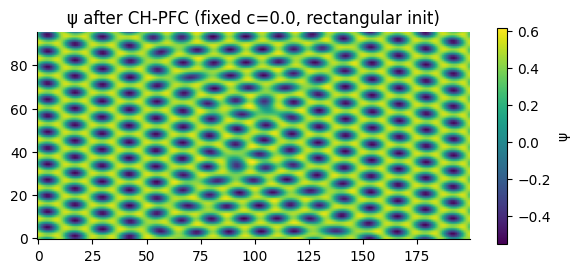

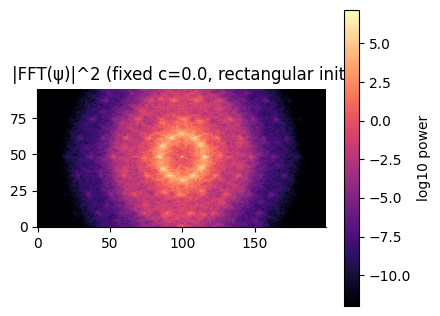


Computed Rectangular Lattice Metrics (fixed c=0.0):
  avg_lattice_constant_x: 12.5000
  avg_lattice_constant_y: nan
  avg_peak_kx: 0.5027
  avg_peak_ky: nan
  k_magnitude_variation: 0.2392
  angle_deviation_from_90: 7.2458
  peak_magnitudes: ['3356609.4440', '3356609.4440', '2966200.4675', '2966200.4675', '2874935.9173', '2874935.9173']

Expected dimensionless lattice constant in x (at c=0): 9.8211
Expected dimensionless lattice constant in y (at c=0): 4.7880


In [119]:
ny, nx = 96, 200 # Or your desired grid size
c0 = np.full((ny, nx), 0.0) # Initialize with uniform concentration at c=0.0
C_uniform_c0 = make_dopant_field(c0.shape, kind="uniform", value=P.C_dopant_scalar) # Uniform dopant field

print(f"Starting simulation at fixed c=0.0 with rectangular lattice initialization on {ny}x{nx} grid...")

# Run the simulation
c_u, psi_u, _ = run_quasistatic_CHPFC(
    c0.copy(),
    n_steps=500, # Sufficient steps for stabilization
    snapshot_every=301, # Only get the final snapshot
    C_dop_field=C_uniform_c0, # Use uniform dopant
    psi_init_method="lattice", # Use lattice initialization (now rectangular)
    # No specific 'pattern' param needed, it defaults to rectangular based on c_avg
    psi_init_params={}
)

print("Simulation finished. Plotting results...")

# Plot the resulting psi field
plot_psi(psi_u, title="ψ after CH-PFC (fixed c=0.0, rectangular init)")

# Plot the reciprocal lattice
plot_reciprocal_lattice(psi_u, title="|FFT(ψ)|^2 (fixed c=0.0, rectangular init)")

# Compute and print lattice metrics (you might need to tune parameters here)
lattice_metrics_c0_rectangular = compute_lattice_metrics(psi_u, distance_peaks=3, k_threshold_axis=0.2) # Example tuned params

if lattice_metrics_c0_rectangular:
    print("\nComputed Rectangular Lattice Metrics (fixed c=0.0):")
    for key, value in lattice_metrics_c0_rectangular.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        elif isinstance(value, list):
            print(f"  {key}: {[f'{v:.4f}' for v in value]}")
        else:
            print(f"  {key}: {value}")
else:
    print("\nCould not compute lattice metrics for fixed c=0.0.")


# Calculate expected lattice constants in real space at c=0.0 (scaled by dx)
expected_a_x_dimless = P.alpha_FP * P.a0 / P.dx
expected_a_y_dimless = P.beta_FP * P.a0 / P.dx

print(f"\nExpected dimensionless lattice constant in x (at c=0): {expected_a_x_dimless:.4f}")
print(f"Expected dimensionless lattice constant in y (at c=0): {expected_a_y_dimless:.4f}")

# Compare measured vs expected
if lattice_metrics_c0_rectangular and not np.isnan(lattice_metrics_c0_rectangular["avg_lattice_constant_x"]) and not np.isnan(lattice_metrics_c0_rectangular["avg_lattice_constant_y"]):
    measured_a_x_dimless = lattice_metrics_c0_rectangular["avg_lattice_constant_x"]
    measured_a_y_dimless = lattice_metrics_c0_rectangular["avg_lattice_constant_y"]

    print("\nComparison of Measured vs Expected Lattice Constants (dimensionless):")
    print(f"  Measured a_x: {measured_a_x_dimless:.4f}, Expected a_x: {expected_a_x_dimless:.4f}")
    print(f"  Measured a_y: {measured_a_y_dimless:.4f}, Expected a_y: {expected_a_y_dimless:.4f}")

    # Calculate percentage difference
    diff_a_x_pct = np.abs(measured_a_x_dimless - expected_a_x_dimless) / expected_a_x_dimless * 100 if expected_a_x_dimless > 1e-9 else np.nan
    diff_a_y_pct = np.abs(measured_a_y_dimless - expected_a_y_dimless) / expected_a_y_dimless * 100 if expected_a_y_dimless > 1e-9 else np.nan

    print(f"  Percentage difference a_x: {diff_a_x_pct:.2f}%")
    print(f"  Percentage difference a_y: {diff_a_y_pct:.2f}%")


Overlayed detected rectangular lattice with periods: a_x = 12.50 grid units, a_y = 5.82 grid units


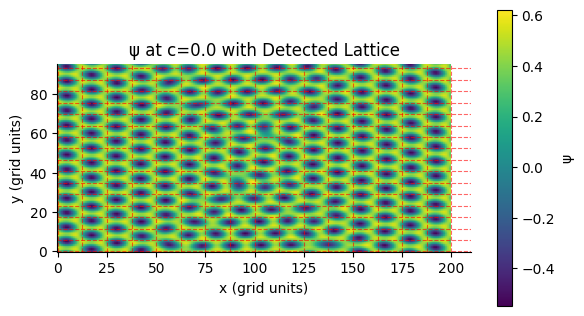

In [120]:
plot_psi_with_lattice_overlay(psi_u, lattice_metrics_c0_square, title="ψ at c=0.0 with Detected Lattice")

Starting simulation at fixed c=0.0 with square lattice initialization...


Running simulation:   0%|          | 0/50 [00:00<?, ?it/s]

Simulation finished. Plotting results...


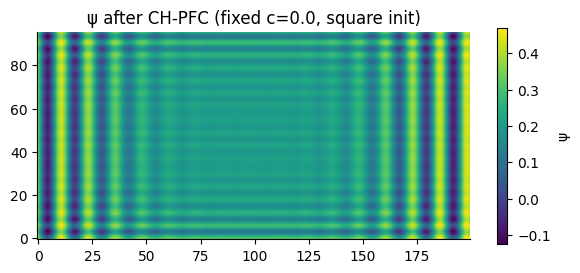

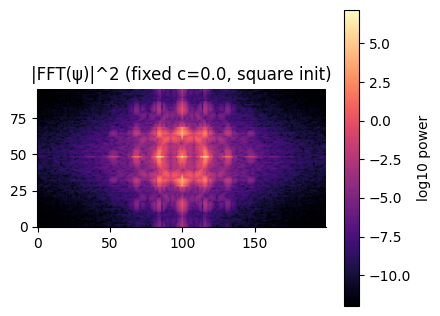


Computed Lattice Metrics (fixed c=0.0, square init):
  avg_lattice_constant_x: 12.5000
  avg_lattice_constant_y: 5.8182
  avg_peak_kx: 0.5027
  avg_peak_ky: 1.0799
  k_magnitude_variation: 0.3081
  angle_deviation_from_90: 0.0000
  peak_magnitudes: ['811750.4617', '811750.4617', '93234.0307', '93234.0307', '47251.1984', '47251.1984']

Expected dimensionless lattice constant in x (at c=0): 9.8211
Expected dimensionless lattice constant in y (at c=0): 4.7880


In [110]:
ny, nx = 96, 200 # Or your desired grid size
c0 = np.full((ny, nx), 0.0) # Initialize with uniform concentration at c=0.0
C_uniform_c0 = make_dopant_field(c0.shape, kind="uniform", value=P.C_dopant_scalar) # Uniform dopant field (assuming no dopant effect on this test)

print("Starting simulation at fixed c=0.0 with square lattice initialization...")

# Run the simulation
c_u, psi_u, _ = run_quasistatic_CHPFC(
    c0.copy(),
    n_steps=50, # Sufficient steps for stabilization - adjust if needed
    snapshot_every=3001, # Only get the final snapshot
    C_dop_field=C_uniform_c0,
    psi_init_method="lattice", # Initialize psi with a lattice pattern
    psi_init_params={"pattern": "square"} # Specify square pattern
)

print("Simulation finished. Plotting results...")

# Plot the resulting psi field
plot_psi(psi_u, title="ψ after CH-PFC (fixed c=0.0, square init)")

# Plot the reciprocal lattice
plot_reciprocal_lattice(psi_u, title="|FFT(ψ)|^2 (fixed c=0.0, square init)")

# Compute and print lattice metrics
lattice_metrics_c0_square = compute_lattice_metrics(psi_u)

if lattice_metrics_c0_square:
    print("\nComputed Lattice Metrics (fixed c=0.0, square init):")
    for key, value in lattice_metrics_c0_square.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        elif isinstance(value, list):
            print(f"  {key}: {[f'{v:.4f}' for v in value]}")
        else:
            print(f"  {key}: {value}")
else:
    print("\nCould not compute lattice metrics for fixed c=0.0, square init.")

# Calculate expected lattice constants in real space at c=0.0 (scaled by dx)
expected_a_x_dimless = P.alpha_FP * P.a0 / P.dx
expected_a_y_dimless = P.beta_FP * P.a0 / P.dx

print(f"\nExpected dimensionless lattice constant in x (at c=0): {expected_a_x_dimless:.4f}")
print(f"Expected dimensionless lattice constant in y (at c=0): {expected_a_y_dimless:.4f}")


Overlayed detected rectangular lattice with periods: a_x = 12.50 grid units, a_y = 5.82 grid units


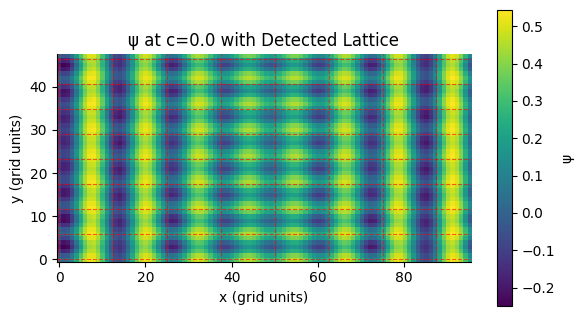

In [113]:
plot_psi_with_lattice_overlay(psi_u, lattice_metrics_c0_square, title="ψ at c=0.0 with Detected Lattice")

In [103]:
4.7880*2


9.576

Starting simulation at fixed c=1.0 with square lattice initialization...


Running simulation:   0%|          | 0/2000 [00:00<?, ?it/s]

Simulation finished. Plotting results...


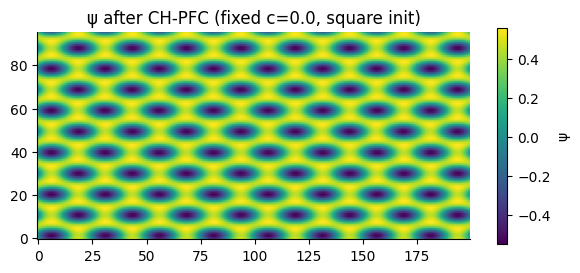

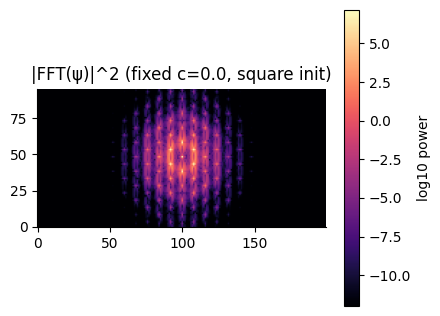


Computed Lattice Metrics (fixed c=0.0, square init):
  avg_lattice_constant_x: nan
  avg_lattice_constant_y: 9.6000
  avg_peak_kx: nan
  avg_peak_ky: 0.6545
  k_magnitude_variation: 0.2312
  angle_deviation_from_90: 0.0000
  peak_magnitudes: ['5587409.5257', '5587409.5257', '5551150.8729', '5551150.8729', '5542363.1678', '5542363.1678']

Expected dimensionless lattice constant in x (at c=0): 10.3339
Expected dimensionless lattice constant in y (at c=0): 4.6932


In [95]:
ny, nx = 96, 200 # Or your desired grid size
c0 = np.full((ny, nx), 1.0) # Initialize with uniform concentration at c=0.0
C_uniform_c0 = make_dopant_field(c0.shape, kind="uniform", value=P.C_dopant_scalar) # Uniform dopant field (assuming no dopant effect on this test)

print("Starting simulation at fixed c=1.0 with square lattice initialization...")

# Run the simulation
c_u, psi_u, _ = run_quasistatic_CHPFC(
    c0.copy(),
    n_steps=2000, # Sufficient steps for stabilization - adjust if needed
    snapshot_every=2001, # Only get the final snapshot
    C_dop_field=C_uniform_c0,
    psi_init_method="lattice", # Initialize psi with a lattice pattern
    psi_init_params={"pattern": "square"} # Specify square pattern
)

print("Simulation finished. Plotting results...")

# Plot the resulting psi field
plot_psi(psi_u, title="ψ after CH-PFC (fixed c=1.0, square init)")

# Plot the reciprocal lattice
plot_reciprocal_lattice(psi_u, title="|FFT(ψ)|^2 (fixed c=1.0, square init)")

# Compute and print lattice metrics
lattice_metrics_c0_square = compute_lattice_metrics(psi_u)

if lattice_metrics_c0_square:
    print("\nComputed Lattice Metrics (fixed c=1.0, square init):")
    for key, value in lattice_metrics_c0_square.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        elif isinstance(value, list):
            print(f"  {key}: {[f'{v:.4f}' for v in value]}")
        else:
            print(f"  {key}: {value}")
else:
    print("\nCould not compute lattice metrics for fixed c=1.0, square init.")

# Calculate expected lattice constants in real space at c=1.0 (scaled by dx)
expected_a_x_dimless = P.alpha_LFP * P.a0 / P.dx
expected_a_y_dimless = P.beta_LFP * P.a0 / P.dx

print(f"\nExpected dimensionless lattice constant in x (at c=0): {expected_a_x_dimless:.4f}")
print(f"Expected dimensionless lattice constant in y (at c=0): {expected_a_y_dimless:.4f}")

# Tests for c=1 and c=0

In [82]:
ny, nx = 128, 128

#c0 = demo_build_initial_profile(nx=nx, ny=ny)
c0 = np.full((ny,nx), 1.0) # Initialize with uniform concentration
C_uniform  = make_dopant_field(c0.shape, kind="uniform",    value=P.C_dopant_scalar)
#C_gradient = make_dopant_field(c0.shape, kind="gradient-x", value=0.2)
c_u, psi_u, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=50, snapshot_every=50, C_dop_field=C_uniform,  psi_init_method="lattice", psi_init_params={"pattern": "square"})
#c_g, psi_g, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=50, snapshot_every=50, C_dop_field=C_gradient,  psi_init_method="lattice", psi_init_params={"pattern": "hexagonal"})
#compute_and_plot_stress(c_u, "Uniform dopant")
#compute_and_plot_stress(c_g, "Gradient dopant")

Running simulation:   0%|          | 0/50 [00:00<?, ?it/s]

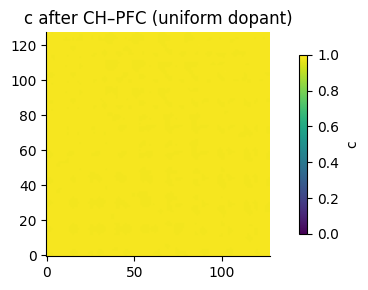

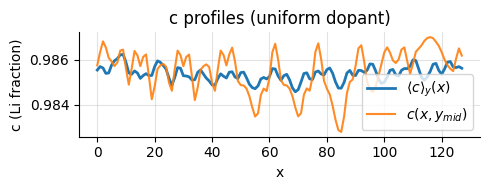

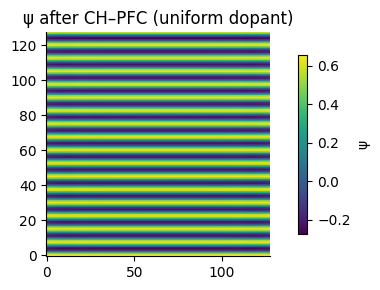

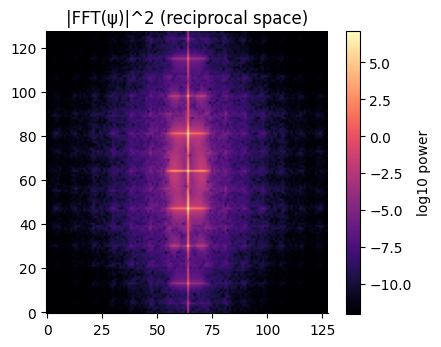


peak Metrics:
{'num_peaks_found': 78, 'square_peak_count': np.int64(6), 'hexagonal_peak_count': 0, 'squareness_ratio': np.float64(1.0), 'peak_distance_variation': np.float64(0.04802921064280742), 'peak_angle_variation': np.float64(0.0)}
Average dimensionless mixing free energy density: -0.006489
Total dimensionless mixing free energy: -106.309480
Average mixing free energy density (J/mol): -16.08
Total mixing free energy (J): -263389.39


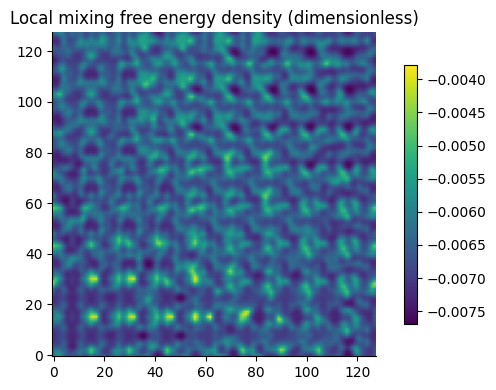

In [83]:
# After uniform dopant run:
plot_concentration_2d(c_u, title="c after CH–PFC (uniform dopant)")
plot_concentration_profiles(c_u, title="c profiles (uniform dopant)")
plot_psi(psi_u, title="ψ after CH–PFC (uniform dopant)")

plot_reciprocal_lattice(psi_u)   # optional lattice check
metrics = quantify_peaks(psi_u)
print("\npeak Metrics:")
print(metrics)
# After gradient dopant run:
#plot_concentration_2d(c_g, title="c after CH–PFC (dopant gradient)")
#plot_concentration_profiles(c_g, title="c profiles (dopant gradient)")
#plot_psi(psi_g, title="ψ after CH–PFC (dopant gradient)")
# plot_reciprocal_lattice(psi_g)   # optional lattice check

# Calculate local mixing free energy density
local_mixing_fe_density = free_energy_density_dimless(c_u, C_dop=C_uniform)

# Calculate average mixing free energy density over the domain
average_mixing_fe_density = np.mean(local_mixing_fe_density)

# Calculate total mixing free energy (sum over grid and multiply by cell area)
total_mixing_fe = np.sum(local_mixing_fe_density) * (P.dx * P.dx)

print(f"Average dimensionless mixing free energy density: {average_mixing_fe_density:.6f}")
print(f"Total dimensionless mixing free energy: {total_mixing_fe:.6f}")

# You can also convert this to J/mol if you multiply by RT
average_mixing_fe_dimensional = average_mixing_fe_density / P.fe_scale
total_mixing_fe_dimensional = total_mixing_fe / P.fe_scale

print(f"Average mixing free energy density (J/mol): {average_mixing_fe_dimensional:.2f}")
print(f"Total mixing free energy (J): {total_mixing_fe_dimensional:.2f}")

# Display the spatial distribution of the local mixing free energy density
show_field(local_mixing_fe_density, title="Local mixing free energy density (dimensionless)")

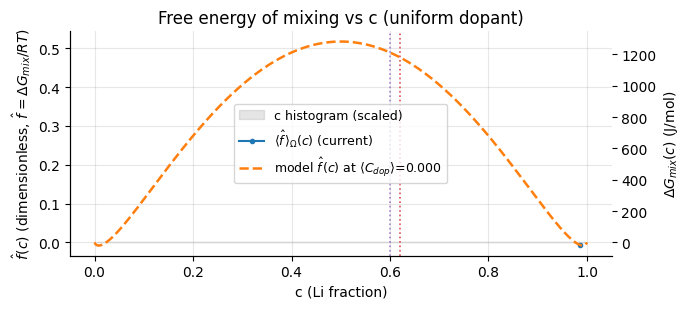

In [80]:
plot_free_energy_of_mixing(c_u, C_dop_field=C_uniform,
                           title="Free energy of mixing vs c (uniform dopant)")

#plot_free_energy_of_mixing(c_g, C_dop_field=C_gradient,
#                           title="Free energy of mixing vs c (dopant gradient)")

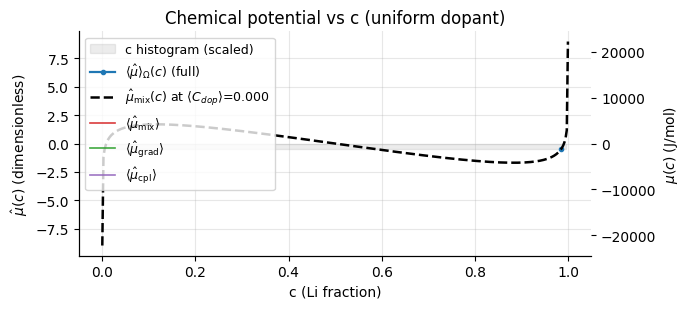

In [81]:
plot_chemical_potential(c_u, psi_u, C_dop_field=C_uniform,
                        decompose=True,
                        title="Chemical potential vs c (uniform dopant)")

#plot_chemical_potential(c_g, psi_g, C_dop_field=C_gradient,
#                        decompose=True,
#                        title="Chemical potential vs c (dopant gradient)")

In [75]:
ny, nx = 363, 363
#c0 = demo_build_initial_profile(nx=nx, ny=ny)
c0 = np.full((ny,nx), 0.0) # Initialize with uniform concentration
C_uniform  = make_dopant_field(c0.shape, kind="uniform",    value=P.C_dopant_scalar)
#C_gradient = make_dopant_field(c0.shape, kind="gradient-x", value=0.2)
c_u, psi_u, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=100, snapshot_every=50, C_dop_field=C_uniform,  psi_init_method="lattice", psi_init_params={"pattern": "square"})
#c_g, psi_g, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=50, snapshot_every=200, C_dop_field=C_gradient,  psi_init_method="lattice", psi_init_params={"pattern": "hexagonal"})
#compute_and_plot_stress(c_u, "Uniform dopant")
#compute_and_plot_stress(c_g, "Gradient dopant")

Running simulation:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

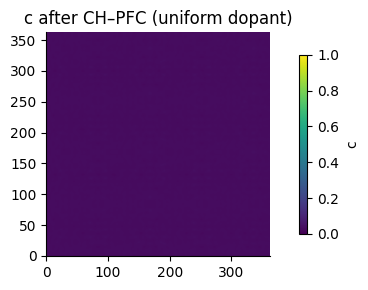

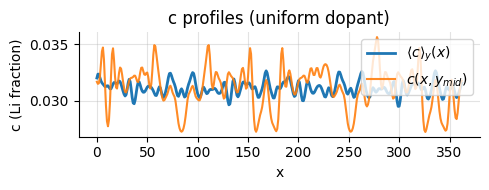

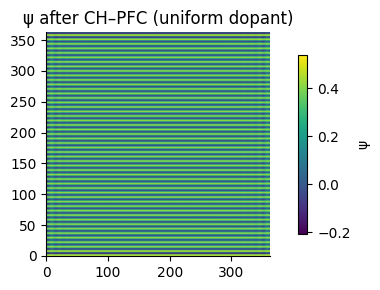

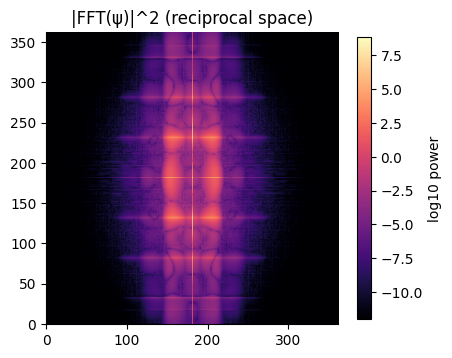


peak Metrics:
{'num_peaks_found': 616, 'square_peak_count': np.int64(6), 'hexagonal_peak_count': 0, 'squareness_ratio': np.float64(1.0), 'peak_distance_variation': np.float64(0.016329931618554533), 'peak_angle_variation': np.float64(0.0)}
Average dimensionless mixing free energy density: 0.007424
Total dimensionless mixing free energy: 978.189656
Average mixing free energy density (J/mol): 18.39
Total mixing free energy (J): 2423535.30


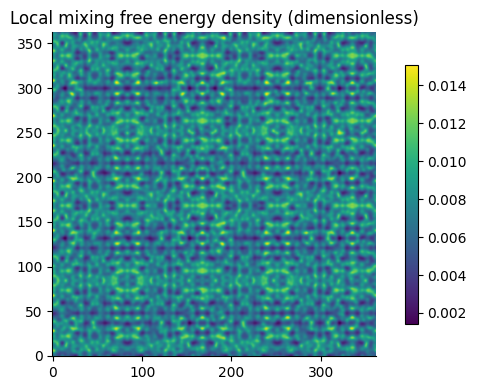

In [41]:
# After uniform dopant run:
plot_concentration_2d(c_u, title="c after CH–PFC (uniform dopant)")
plot_concentration_profiles(c_u, title="c profiles (uniform dopant)")
plot_psi(psi_u, title="ψ after CH–PFC (uniform dopant)")

plot_reciprocal_lattice(psi_u)   # optional lattice check
metrics = quantify_peaks(psi_u)
print("\npeak Metrics:")
print(metrics)

# After gradient dopant run:
#plot_concentration_2d(c_g, title="c after CH–PFC (dopant gradient)")
#plot_concentration_profiles(c_g, title="c profiles (dopant gradient)")
#plot_psi(psi_g, title="ψ after CH–PFC (dopant gradient)")
# plot_reciprocal_lattice(psi_g)   # optional lattice check

# Calculate local mixing free energy density
local_mixing_fe_density = free_energy_density_dimless(c_u, C_dop=C_uniform)

# Calculate average mixing free energy density over the domain
average_mixing_fe_density = np.mean(local_mixing_fe_density)

# Calculate total mixing free energy (sum over grid and multiply by cell area)
total_mixing_fe = np.sum(local_mixing_fe_density) * (P.dx * P.dx)

print(f"Average dimensionless mixing free energy density: {average_mixing_fe_density:.6f}")
print(f"Total dimensionless mixing free energy: {total_mixing_fe:.6f}")

# You can also convert this to J/mol if you multiply by RT
average_mixing_fe_dimensional = average_mixing_fe_density / P.fe_scale
total_mixing_fe_dimensional = total_mixing_fe / P.fe_scale

print(f"Average mixing free energy density (J/mol): {average_mixing_fe_dimensional:.2f}")
print(f"Total mixing free energy (J): {total_mixing_fe_dimensional:.2f}")

# Display the spatial distribution of the local mixing free energy density
show_field(local_mixing_fe_density, title="Local mixing free energy density (dimensionless)")

In [ ]:
plot_free_energy_of_mixing(c_u, C_dop_field=C_uniform,
                           title="Free energy of mixing vs c (uniform dopant)")

#plot_free_energy_of_mixing(c_g, C_dop_field=C_gradient,
#                           title="Free energy of mixing vs c (dopant gradient)")

In [ ]:
plot_chemical_potential(c_u, psi_u, C_dop_field=C_uniform,
                        decompose=True,
                        title="Chemical potential vs c (uniform dopant)")

#plot_chemical_potential(c_g, psi_g, C_dop_field=C_gradient,
#                        decompose=True,
#                        title="Chemical potential vs c (dopant gradient)")

# Diffuse interphase

In [ ]:
ny, nx = 30, 200
P.kappa=20
c0 = demo_build_initial_profile(nx=nx, ny=ny)
#c0 = np.full((ny,nx), 0.0) # Initialize with uniform concentration
C_uniform  = make_dopant_field(c0.shape, kind="uniform",    value=P.C_dopant_scalar)
#C_gradient = make_dopant_field(c0.shape, kind="gradient-x", value=0.2)
#c_u, psi_u, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=50, snapshot_every=50, C_dop_field=C_uniform,  psi_init_method="lattice", psi_init_params={"pattern": "square"})
c_u, psi_u, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=500, snapshot_every=50, C_dop_field=C_uniform,  psi_init_method="random")
#c_g, psi_g, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=50, snapshot_every=50, C_dop_field=C_gradient

#c_g, psi_g, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=50, snapshot_every=50, C_dop_field=C_gradient,  psi_init_method="lattice", psi_init_params={"pattern": "hexagonal"})
#compute_and_plot_stress(c_u, "Uniform dopant")
#compute_and_plot_stress(c_g, "Gradient dopant")


Now I want to evolve the system in time allowing for simulations of phase simulation given a starting lattice with a certain Li concentration. I want to simulate the phase separation in time. How would I o that?

In [ ]:
# After uniform dopant run:
plot_concentration_2d(c_u, title="c after CH–PFC (uniform dopant)")
plot_concentration_profiles(c_u, title="c profiles (uniform dopant)")
plot_psi(psi_u, title="ψ after CH–PFC (uniform dopant)")
plot_reciprocal_lattice(psi_u)   # optional lattice check



# Calculate local mixing free energy density
local_mixing_fe_density = free_energy_density_dimless(c_u, C_dop=C_uniform)

# Calculate average mixing free energy density over the domain
average_mixing_fe_density = np.mean(local_mixing_fe_density)

# Calculate total mixing free energy (sum over grid and multiply by cell area)
total_mixing_fe = np.sum(local_mixing_fe_density) * (P.dx * P.dx)

print(f"Average dimensionless mixing free energy density: {average_mixing_fe_density:.6f}")
print(f"Total dimensionless mixing free energy: {total_mixing_fe:.6f}")

# You can also convert this to J/mol if you multiply by RT
average_mixing_fe_dimensional = average_mixing_fe_density / P.fe_scale
total_mixing_fe_dimensional = total_mixing_fe / P.fe_scale

print(f"Average mixing free energy density (J/mol): {average_mixing_fe_dimensional:.2f}")
print(f"Total mixing free energy (J): {total_mixing_fe_dimensional:.2f}")

# Display the spatial distribution of the local mixing free energy density
show_field(local_mixing_fe_density, title="Local mixing free energy density (dimensionless)")

In [ ]:
plot_free_energy_of_mixing(c_u, C_dop_field=C_uniform,
                           title="Free energy of mixing vs c (uniform dopant)")

#plot_free_energy_of_mixing(c_g, C_dop_field=C_gradient,
#                           title="Free energy of mixing vs c (dopant gradient)")

In [ ]:
plot_chemical_potential(c_u, psi_u, C_dop_field=C_uniform,
                        decompose=True,
                        title="Chemical potential vs c (uniform dopant)")

#plot_chemical_potential(c_g, psi_g, C_dop_field=C_gradient,
#                        decompose=True,
#                        title="Chemical potential vs c (dopant gradient)")

# More detailed analysis

In [ ]:
def plot_concentration_and_psi_contours(c, psi, title="Concentration with Psi Contours"):
    """
    Plots the concentration field as an image with psi contours overlaid.

    Parameters
    ----------
    c : 2D array
        The concentration field.
    psi : 2D array
        The psi field.
    title : str
        Title for the plot.
    """
    plt.figure(figsize=(6, 4))

    # Plot the concentration field as an image
    im = plt.imshow(c, origin='lower', cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(im, shrink=0.8, label='c')

    # Plot contours of the psi field
    # You might need to adjust the contour levels based on the typical range of your psi values
    # Here we plot contours at certain positive psi values to highlight lattice sites
    contour_levels = np.linspace(psi.min(), psi.max(), 10) # Example: 10 contour levels across the range
    # Or specify specific levels, e.g., contour_levels = [0.2, 0.3, 0.4]
    plt.contour(psi, levels=contour_levels, colors='w', linewidths=0.8, alpha=0.7)


    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# Assuming c_u and psi_u are available from a simulation run
plot_concentration_and_psi_contours(c_u, psi_u, title="c and psi contours (Uniform dopant)")

In [ ]:
def plot_local_reciprocal_lattice(psi, x_center, window_width, title=""):
    """
    Plots the reciprocal lattice for a vertical strip of the psi field.

    Parameters
    ----------
    psi : 2D array
        The psi field.
    x_center : int
        The x-coordinate of the center of the vertical strip.
    window_width : int
        The width of the vertical strip.
    title : str
        Title for the plot.
    """
    ny, nx = psi.shape
    x_start = max(0, x_center - window_width // 2)
    x_end = min(nx, x_center + window_width // 2)

    if x_end - x_start < window_width:
        print(f"Warning: Window clipped at boundary. Actual width: {x_end - x_start}")

    local_psi = psi[:, x_start:x_end]

    # Apply a window function to reduce spectral leakage (e.g., a 2D Tukey window)
    # A simple 1D Tukey window applied to each column is a start.
    # More sophisticated 2D windowing might be needed for quantitative analysis.
    tukey_window = np.outer(np.ones(ny), np.hanning(x_end - x_start))
    local_psi_windowed = local_psi * tukey_window


    Pk = np.fft.fftshift(np.abs(np.fft.fft2(local_psi_windowed))**2)

    plt.figure(figsize=(4.5,4))
    im = plt.imshow(np.log10(Pk + 1e-12), origin='lower', cmap='magma')
    plt.colorbar(im, shrink=0.8, label='log10 power')
    # Adjust extent to reflect k-space
    ky = np.fft.fftfreq(ny, d=P.dx) * 2*np.pi
    kx = np.fft.fftfreq(x_end - x_start, d=P.dx) * 2*np.pi
    plt.xticks(np.arange(len(kx)), [f'{k:.1f}' for k in np.fft.fftshift(kx)])
    plt.yticks(np.arange(len(ky)), [f'{k:.1f}' for k in np.fft.fftshift(ky)])
    plt.xlabel('$k_x$')
    plt.ylabel('$k_y$')


    plt.title(title)
    plt.tight_layout(); plt.show()

# --- Analyze local symmetry across the interface ---
# Assuming c_u and psi_u from a simulation with an interface
# If you used demo_build_initial_profile, the interface is around x=40

# Define window parameters
window_width = 32 # pixels
x_positions = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200] # x-coordinates for the center of each window

# Run local analysis for each position
for x_center in x_positions:
    plot_local_reciprocal_lattice(psi_u, x_center, window_width,
                                  title=f"Local Reciprocal Lattice at x={x_center} (Uniform dopant)")

# If you also ran a simulation with a gradient (e.g., c_g, psi_g)
# for x_center in x_positions:
#     plot_local_reciprocal_lattice(psi_g, x_center, window_width,
#                                   title=f"Local Reciprocal Lattice at x={x_center} (Gradient dopant)")

In [ ]:
def plot_psi_with_lattice_overlay(psi, lattice_metrics, title="ψ with Detected Rectangular Lattice"):
    """
    Plots the psi field and overlays grid lines representing the detected
    rectangular lattice based on computed metrics.

    Parameters
    ----------
    psi : 2D array
        The psi field (real space).
    lattice_metrics : dict or None
        The dictionary returned by compute_lattice_metrics.
    title : str
        Title for the plot.
    """
    ny, nx = psi.shape

    plt.figure(figsize=(6, 4))
    im = plt.imshow(psi, origin='lower', cmap='viridis')
    plt.colorbar(im, shrink=0.8, label='ψ')

    plt.title(title)
    plt.xlabel("x (grid units)")
    plt.ylabel("y (grid units)")

    if lattice_metrics and not np.isnan(lattice_metrics.get('avg_lattice_constant_x', np.nan)) \
                       and not np.isnan(lattice_metrics.get('avg_lattice_constant_y', np.nan)):

        # Get measured lattice constants in grid units
        measured_a_x_gu = lattice_metrics['avg_lattice_constant_x'] / P.dx
        measured_a_y_gu = lattice_metrics['avg_lattice_constant_y'] / P.dx

        if measured_a_x_gu > 1e-3 and measured_a_y_gu > 1e-3: # Check for valid non-zero constants
            # Generate lattice points or lines
            # Let's draw grid lines at the detected lattice periods
            # We need to pick a starting point (e.g., closest lattice site to origin)
            # For simplicity, let's draw lines starting from 0 based on the measured periods.

            # Vertical lines (at x = n * a_x)
            for n in range(int(nx // measured_a_x_gu) + 2):
                 x_pos = n * measured_a_x_gu
                 if x_pos < nx:
                    plt.axvline(x_pos, color='r', linestyle='--', lw=0.8, alpha=0.6)

            # Horizontal lines (at y = m * a_y)
            for m in range(int(ny // measured_a_y_gu) + 2):
                 y_pos = m * measured_a_y_gu
                 if y_pos < ny:
                    plt.axhline(y_pos, color='r', linestyle='--', lw=0.8, alpha=0.6)

            print(f"Overlayed detected rectangular lattice with periods: a_x = {measured_a_x_gu:.2f} grid units, a_y = {measured_a_y_gu:.2f} grid units")
        else:
             print("Detected lattice constants are too small or invalid for overlay.")

    else:
        print("Lattice metrics not available or invalid for overlay.")


    plt.tight_layout()
    plt.show()

# --- Example Usage (after running a simulation and computing metrics) ---
# Assuming psi_u is the psi field and lattice_metrics_c0_square contains the computed metrics
#
# # First, run a simulation and compute metrics as shown before
# ny, nx = 48, 96
# c0 = np.full((ny, nx), 0.0)
# C_uniform = make_dopant_field(c0.shape, kind="uniform", value=P.C_dopant_scalar)
# c_u, psi_u, _ = run_quasistatic_CHPFC(c0.copy(), n_steps=1000, snapshot_every=1001,
#                                       C_dop_field=C_uniform,
#                                       psi_init_method="lattice", psi_init_params={"pattern": "square"})
#
# # Then, compute the lattice metrics (adjust parameters if needed)
# lattice_metrics_c0_square = compute_lattice_metrics(psi_u, distance_peaks=3, k_threshold_axis=0.2)
#
# # Finally, plot psi with the lattice overlay
# plot_psi_with_lattice_overlay(psi_u, lattice_metrics_c0_square, title="ψ at c=0.0 with Detected Lattice")

In [ ]:
# Now that the functions are defined, run the analysis again
# Use quantify_squareness to get a general assessment of the pattern
squareness_metrics_c0_square = quantify_squareness(psi_u)

print("\nSquareness Metrics (fixed c=0.0, square init):")
for key, value in squareness_metrics_c0_square.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    elif isinstance(value, list):
        print(f"  {key}: {[f'{v:.4f}' for v in value]}")
    else:
        print(f"  {key}: {value}")

# Re-print the basic lattice metrics, even with NaNs, for any potentially useful info
# Need to re-compute lattice_metrics_c0_square as the function was just redefined
lattice_metrics_c0_square = compute_lattice_metrics(psi_u)

print("\nComputed Lattice Metrics (fixed c=0.0, square init) - Raw Output:")
if lattice_metrics_c0_square:
     for key, value in lattice_metrics_c0_square.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        elif isinstance(value, list):
            print(f"  {key}: {[f'{v:.4f}' for v in value]}")
        else:
            print(f"  {key}: {value}")
else:
    print("  Could not compute lattice metrics.")

# Re-print expected values
expected_a_x_dimless = P.alpha_FP * P.a0 / P.dx
expected_a_y_dimless = P.beta_FP * P.a0 / P.dx

print(f"\nExpected dimensionless lattice constant in x (at c=0): {expected_a_x_dimless:.4f}")
print(f"Expected dimensionless lattice constant in y (at c=0): {expected_a_y_dimless:.4f}")

# Although direct comparison of a_x and a_y failed, we can still comment on the overall squareness
print("\nAssessment of Square Pattern Stability (based on quantify_squareness):")
square_peak_count = squareness_metrics_c0_square.get("square_peak_count", 0)
hexagonal_peak_count = squareness_metrics_c0_square.get("hexagonal_peak_count", 0)
squareness_ratio = squareness_metrics_c0_square.get("squareness_ratio", np.nan)
angle_dev = squareness_metrics_c0_square.get("peak_angle_variation", np.nan)
k_var = squareness_metrics_c0_square.get("peak_distance_variation", np.nan)


if square_peak_count >= 4 and squareness_ratio > 0.8 and (np.isnan(angle_dev) or angle_dev < 15) and (np.isnan(k_var) or k_var < 0.1):
     print("  The analysis suggests a stable square-like pattern formed.")
     print("  Note: Direct lattice constant measurement based on axis-aligned peaks failed, possibly due to peak alignment or detection threshold.")
elif hexagonal_peak_count >= 6:
     print("  The analysis suggests a hexagonal-like pattern formed instead of square.")
else:
     print("  The pattern analysis is inconclusive or did not yield a clear square or hexagonal lattice.")